# TOXIGUARD

## 1) Import dependencies

In [85]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


## 2)Know the data

In [86]:
df = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv')

In [87]:
df[(df['severe_toxic'] == 1) & (df['toxic'] == 1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0
579,018663f910e0bfe6,What a motherfucking piece of crap those fuckh...,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...
159096,f871b05d4caa6f20,"You filthy, stinking crow! \n\nI am back! Dirt...",1,1,1,0,1,0
159099,f885a3e2d779342e,now\n\nyou fucking pathetic moron. \n\ncc: Ji...,1,1,1,0,1,0
159281,fb726deec64157bd,LoL!! \n\nyou're GAY!! you will never know how...,1,1,1,0,1,1
159312,fbf20e312cd4a78d,"Walter Mercado \n\nAntonio, quite frankly, you...",1,1,1,0,1,0


Observe that when a comment is severe toxic, it is also toxic, to simplify our model we will just remove the severely toxic column. This decision was made because there is no clear boundary of differences between the two categories: toxic and severe_toxic

In [88]:
df = df.drop(columns=['severe_toxic'])

In [89]:
df.head()

,id,comment_text,toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0


## 3) Preprocess the data

In [90]:
from tensorflow.keras.layers import TextVectorization

In [91]:
X = df['comment_text']
y = df[['toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [92]:
MODEL_PATH = 'best_model.h5'
MAX_FEATURES = 200000

In [93]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [94]:
vectorizer.adapt(X.values)

In [95]:
vectorized_text = vectorizer(X.values)

In [96]:
# Create tf.data.Dataset
dataset_size = len(vectorized_text)
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)).cache().shuffle(dataset_size)

In [97]:
# Train/val/test split
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size).batch(32).prefetch(8)
val_dataset = dataset.skip(train_size).take(val_size).batch(32).prefetch(8)
test_dataset = dataset.skip(train_size + val_size).batch(32).prefetch(8)

## 4) Fix imbalance using weighted BCE

In [98]:
# Calculate per-label class weights
label_totals = y.sum(axis=0)
class_weights = dataset_size / (label_totals + 1e-6)
normalized_weights = class_weights / class_weights.sum()

print("Per-label weights:", normalized_weights)

# Define weighted BCE loss
def get_weighted_bce(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def weighted_bce(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    return weighted_bce

weighted_loss = get_weighted_bce(normalized_weights)

Per-label weights: [0.02099386 0.03800214 0.67171557 0.04076172 0.22852672]


## 5) Sequential model

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [100]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES + 1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
# Multi-label output
model.add(Dense(5, activation='sigmoid'))

In [101]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [102]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [103]:
checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

## 6) Training the model

In [104]:
# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9522 - loss: 0.1021 - precision_3: 0.7093 - recall_3: 0.4516

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1927s 552ms/step - accuracy: 0.9522 - loss: 0.1021 - precision_3: 0.7093 - recall_3: 0.4517 - val_accuracy: 0.9940 - val_loss: 0.0508 - val_precision_3: 0.7631 - val_recall_3: 0.7863
Epoch 2/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9923 - loss: 0.0506 - precision_3: 0.8231 - recall_3: 0.7172

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1428s 409ms/step - accuracy: 0.9923 - loss: 0.0506 - precision_3: 0.8231 - recall_3: 0.7172 - val_accuracy: 0.9942 - val_loss: 0.0465 - val_precision_3: 0.8673 - val_recall_3: 0.6893
Epoch 3/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9931 - loss: 0.0444 - precision_3: 0.8394 - recall_3: 0.7427

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1344s 385ms/step - accuracy: 0.9931 - loss: 0.0444 - precision_3: 0.8394 - recall_3: 0.7427 - val_accuracy: 0.9941 - val_loss: 0.0403 - val_precision_3: 0.8717 - val_recall_3: 0.7434
Epoch 4/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9905 - loss: 0.0409 - precision_3: 0.8492 - recall_3: 0.7722

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1429s 409ms/step - accuracy: 0.9905 - loss: 0.0409 - precision_3: 0.8492 - recall_3: 0.7722 - val_accuracy: 0.9940 - val_loss: 0.0368 - val_precision_3: 0.8442 - val_recall_3: 0.8293
Epoch 5/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9939 - loss: 0.0361 - precision_3: 0.8625 - recall_3: 0.8004

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1334s 382ms/step - accuracy: 0.9939 - loss: 0.0361 - precision_3: 0.8625 - recall_3: 0.8004 - val_accuracy: 0.9945 - val_loss: 0.0301 - val_precision_3: 0.8766 - val_recall_3: 0.8564
Epoch 6/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9933 - loss: 0.0315 - precision_3: 0.8707 - recall_3: 0.8345

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1624s 465ms/step - accuracy: 0.9933 - loss: 0.0315 - precision_3: 0.8707 - recall_3: 0.8345 - val_accuracy: 0.9943 - val_loss: 0.0283 - val_precision_3: 0.8785 - val_recall_3: 0.8646
Epoch 7/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9937 - loss: 0.0282 - precision_3: 0.8859 - recall_3: 0.8599

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1471s 421ms/step - accuracy: 0.9937 - loss: 0.0282 - precision_3: 0.8859 - recall_3: 0.8599 - val_accuracy: 0.9924 - val_loss: 0.0247 - val_precision_3: 0.9140 - val_recall_3: 0.8544
Epoch 8/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9699 - loss: 0.0255 - precision_3: 0.8906 - recall_3: 0.8800

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1546s 443ms/step - accuracy: 0.9699 - loss: 0.0255 - precision_3: 0.8906 - recall_3: 0.8800 - val_accuracy: 0.9879 - val_loss: 0.0215 - val_precision_3: 0.9161 - val_recall_3: 0.9045
Epoch 9/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9836 - loss: 0.0222 - precision_3: 0.9030 - recall_3: 0.9015

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1416s 406ms/step - accuracy: 0.9836 - loss: 0.0222 - precision_3: 0.9030 - recall_3: 0.9015 - val_accuracy: 0.9873 - val_loss: 0.0192 - val_precision_3: 0.9143 - val_recall_3: 0.9168
Epoch 10/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9831 - loss: 0.0201 - precision_3: 0.9127 - recall_3: 0.9117

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1388s 398ms/step - accuracy: 0.9831 - loss: 0.0201 - precision_3: 0.9127 - recall_3: 0.9117 - val_accuracy: 0.9940 - val_loss: 0.0178 - val_precision_3: 0.9394 - val_recall_3: 0.9062
Epoch 11/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9541 - loss: 0.0168 - precision_3: 0.9314 - recall_3: 0.9208

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1383s 396ms/step - accuracy: 0.9541 - loss: 0.0168 - precision_3: 0.9314 - recall_3: 0.9208 - val_accuracy: 0.9896 - val_loss: 0.0140 - val_precision_3: 0.9496 - val_recall_3: 0.9312
Epoch 12/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9917 - loss: 0.0149 - precision_3: 0.9389 - recall_3: 0.9304

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1339s 384ms/step - accuracy: 0.9917 - loss: 0.0149 - precision_3: 0.9389 - recall_3: 0.9304 - val_accuracy: 0.9833 - val_loss: 0.0124 - val_precision_3: 0.9590 - val_recall_3: 0.9327
Epoch 13/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9495 - loss: 0.0135 - precision_3: 0.9472 - recall_3: 0.9395

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1337s 383ms/step - accuracy: 0.9495 - loss: 0.0135 - precision_3: 0.9472 - recall_3: 0.9395 - val_accuracy: 0.5690 - val_loss: 0.0115 - val_precision_3: 0.9526 - val_recall_3: 0.9502
Epoch 14/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5625 - loss: 0.0112 - precision_3: 0.9527 - recall_3: 0.9485

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1378s 395ms/step - accuracy: 0.5625 - loss: 0.0112 - precision_3: 0.9527 - recall_3: 0.9485 - val_accuracy: 0.9886 - val_loss: 0.0093 - val_precision_3: 0.9654 - val_recall_3: 0.9556
Epoch 15/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9381 - loss: 0.0103 - precision_3: 0.9555 - recall_3: 0.9534

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1356s 389ms/step - accuracy: 0.9382 - loss: 0.0103 - precision_3: 0.9555 - recall_3: 0.9534 - val_accuracy: 0.9792 - val_loss: 0.0088 - val_precision_3: 0.9617 - val_recall_3: 0.9632
Epoch 16/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8686 - loss: 0.0092 - precision_3: 0.9574 - recall_3: 0.9598

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1377s 394ms/step - accuracy: 0.8686 - loss: 0.0092 - precision_3: 0.9574 - recall_3: 0.9598 - val_accuracy: 0.9833 - val_loss: 0.0080 - val_precision_3: 0.9667 - val_recall_3: 0.9666
Epoch 17/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.7398 - loss: 0.0081 - precision_3: 0.9640 - recall_3: 0.9651

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 2385s 683ms/step - accuracy: 0.7398 - loss: 0.0081 - precision_3: 0.9640 - recall_3: 0.9651 - val_accuracy: 0.9928 - val_loss: 0.0073 - val_precision_3: 0.9705 - val_recall_3: 0.9614
Epoch 18/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8575 - loss: 0.0075 - precision_3: 0.9656 - recall_3: 0.9665

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 2863s 820ms/step - accuracy: 0.8575 - loss: 0.0075 - precision_3: 0.9656 - recall_3: 0.9665 - val_accuracy: 0.9921 - val_loss: 0.0067 - val_precision_3: 0.9659 - val_recall_3: 0.9779
Epoch 19/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9693 - loss: 0.0067 - precision_3: 0.9680 - recall_3: 0.9716

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1405s 402ms/step - accuracy: 0.9693 - loss: 0.0067 - precision_3: 0.9680 - recall_3: 0.9716 - val_accuracy: 0.9947 - val_loss: 0.0059 - val_precision_3: 0.9666 - val_recall_3: 0.9811
Epoch 20/20
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7835 - loss: 0.0059 - precision_3: 0.9744 - recall_3: 0.9751

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 1655s 474ms/step - accuracy: 0.7835 - loss: 0.0059 - precision_3: 0.9744 - recall_3: 0.9751 - val_accuracy: 0.1856 - val_loss: 0.0051 - val_precision_3: 0.9764 - val_recall_3: 0.9785


## Evaluating the model's performance

In [105]:
# Evaluate model
loss, accuracy, precision, recall = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Compute F1 score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
print(f"Test F1 Score: {f1_score:.4f}")

499/499 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.1898 - loss: 0.0048 - precision_3: 0.9810 - recall_3: 0.9822
Test Loss: 0.0050
Test Accuracy: 0.1842
Test Precision: 0.9764
Test Recall: 0.9808
Test F1 Score: 0.9786


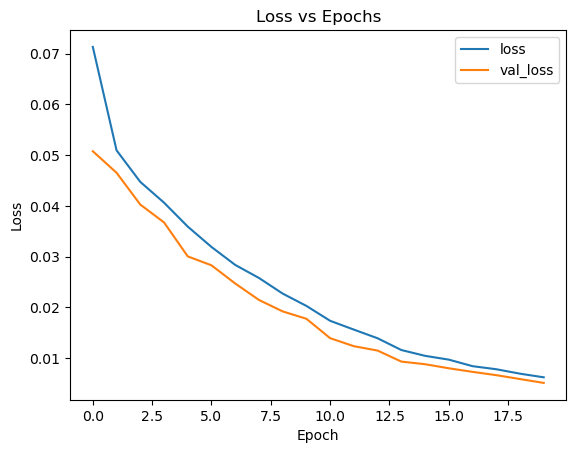

In [107]:
# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()